In [63]:
import numpy as np 
from torch import nn
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
from torch.optim import Adam
from torch.nn import MSELoss,HuberLoss
from torch.nn import init
from gymnasium.wrappers import RecordVideo
# from Exploration.EpsilonGreedyExploration import epsilon_decay,epsilon_greedy,linear_epsilon_decay
from Buffers.ExperienceReplayBuffer import ExperienceReplay
import os
from torch.functional import F


In [64]:
PROJECT_NAME = "NoisyDuellingDQN"
ENV_NAME ="CartPole-v1"
SEED = 13 
LEARNING_RATE = 1e-3
BUFFER_SIZE =20000
GAMMA = 0.99
EPISODES= 701
STEPS=1000
BATCH_SIZE = 64
EPSILON=1.0

In [65]:
from torch.optim.lr_scheduler import StepLR


<center><b>Test and Explore Environment

action_num = 2 | state num = 4


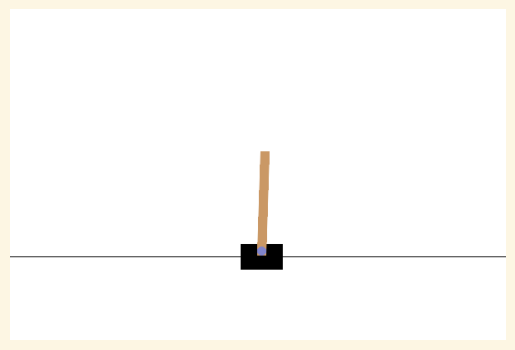

In [66]:
import random
random.seed(13)

env = gym.make(ENV_NAME,render_mode="rgb_array")
video_directory = f'./videos/{PROJECT_NAME}/{ENV_NAME}'
env = RecordVideo(env, video_directory, episode_trigger=lambda episode_id: episode_id % 25 == 0, fps=15)
env.reset(seed=SEED)
state_num  = env.observation_space.shape[0]
action_num= env.action_space.n
print(f"action_num = {action_num} | state num = {state_num}")
plt.imshow(env.render())
plt.axis('off');

In [67]:
import math
device = ("cuda:0"if torch.cuda.is_available() else "cpu" )
from torchinfo import summary
class NoisyLinear(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.weight_mu = nn.Parameter(torch.empty((out_features,in_features)))
        self.weight_sigma = nn.Parameter(torch.empty((out_features,in_features)))
        self.bias_mu = nn.Parameter(torch.empty((out_features)))
        self.bias_sigma = nn.Parameter(torch.empty((out_features)))
        
        init.kaiming_uniform_(self.weight_mu,math.sqrt(5))
        init.kaiming_uniform_(self.weight_sigma,math.sqrt(5))
        init.zeros_(self.bias_mu)
        init.zeros_(self.bias_sigma)
        
    def forward(self,x,sigma = 1.0):
        # false in eval mode 
        if self.training:
            noise_weight = torch.normal(0,sigma,self.weight_sigma.size()).to(x.device)
            noise_bias =torch.normal(0,sigma,self.bias_sigma.size()).to(x.device)
            return F.linear(x,self.weight_mu + self.weight_sigma * noise_weight , self.bias_mu + self.bias_sigma * noise_bias)
        else:
            return F.linear(x,self.weight_mu,self.bias_mu)


In [68]:
class NoisyDuelingNetwork (nn.Module):
    def __init__(self,input_num,h1,h2,h3,output_num):
        super().__init__()
        self.linear1 =NoisyLinear(input_num,h1)
        self.linear2 = NoisyLinear(h1,h2)
        self.linear3 = NoisyLinear(h2,h3)

        self.value = NoisyLinear(h3,1)
        self.advantage = NoisyLinear(h3,output_num)        
        # self.init_weight()
        
    # def init_weight(self):
    #     for module in self.modules():
    #         if isinstance(module,nn.Linear):
    #             init.kaiming_normal_(module.weight,nonlinearity="relu")
    #             if module.bias is not None:
    #                 init.constant_(module.bias,0)
            
    def forward(self,x):

        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = torch.relu(self.linear3(x))
        value = self.value(x)
        advantage = self.advantage(x)
        
        return value + (advantage-torch.mean(advantage,dim=1,keepdim=True)) 

In [69]:

torch.manual_seed(SEED)
model = NoisyDuelingNetwork(state_num,256,128,64,action_num).to((device)) 
target_model = NoisyDuelingNetwork(state_num,256,128,64,action_num).to((device))
target_model.load_state_dict(model.state_dict())
criterion = MSELoss()
optimizer = Adam(model.parameters(),lr=LEARNING_RATE)
scheduler = StepLR(optimizer,200,0.9)
buffer = ExperienceReplay(BUFFER_SIZE,device)
summary(model,(1,state_num))


Layer (type:depth-idx)                   Output Shape              Param #
NoisyDuelingNetwork                      [1, 2]                    --
├─NoisyLinear: 1-1                       [1, 256]                  2,560
├─NoisyLinear: 1-2                       [1, 128]                  65,792
├─NoisyLinear: 1-3                       [1, 64]                   16,512
├─NoisyLinear: 1-4                       [1, 1]                    130
├─NoisyLinear: 1-5                       [1, 2]                    260
Total params: 85,254
Trainable params: 85,254
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.34
Estimated Total Size (MB): 0.34

In [70]:
model.train()
only_exploit = False
rewards = []
total_steps=0

target_model.eval()
for episode in range(EPISODES):
    
    total_reward = 0
    old_observation , _ =env.reset(seed=SEED) 
    
    if episode % 50 == 0 :
        only_exploit = True
        model.eval()
    else:
        model.train()
        only_exploit = False
    
    
    for step in range(STEPS):
        obs = torch.tensor(old_observation).float().reshape(1,-1).to((device))
        action_values:torch.Tensor = model(obs).detach().squeeze()
        action = action_values.argmax().item()
        
        new_observation ,reward,terminated,truncated,_ = env.step(action)
        
        done =  truncated or terminated 
    
        buffer.append(old_observation,action,reward,new_observation,done) 
        old_observation = new_observation
        total_reward+=reward
        
        if(buffer.size() >= BATCH_SIZE):
            old_state,Action,batch_reward,new_state,done = buffer.sample(BATCH_SIZE)
            
            old_state=old_state.float().to((device))
            new_state=new_state .float().to((device))
            Action=Action .long().reshape(-1,1).to((device)) # it should be two dimension for gathering
            batch_reward=batch_reward.reshape(-1,1) .float().to((device))
            done=done.reshape(-1,1).float().to((device))
            
            q_value = model(old_state)
            q_value = q_value.gather(1, Action)
            
            ################
            
            ################
            with torch.no_grad():
                model.eval()
                # target_model is on eval always 
                model_action =torch.argmax(model(new_state),dim=1).reshape(-1,1).long()
                q_value_target= target_model(new_state)
                # best_action = torch.argmax(q_value_target,dim=1).reshape(-1,1).long()
                q_value_target = q_value_target.gather(1, model_action)
                target = batch_reward + GAMMA * q_value_target*(1-done)
                model.train()
                
            loss = criterion(q_value,target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_steps+=1   
        if truncated or terminated:
            break
        
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(current_lr)
    rewards.append(total_reward)
    if  episode % 5  == 0:
        print("Target Updated")
        target_model.load_state_dict(model.state_dict())
    if only_exploit:
        print(f"Exploit Result = {total_reward}")
    #decay = 1/(EPISODES*0.9) # 90 percent of episodes will decrease

    print(f"Episode {episode:4d} | Reward: {total_reward:.2f} ")
    
# import os 
# os.mkdir(f"../{ENV_NAME}")
# torch.save(model.state_dict(),f"./{ENV_NAME}/Model.pth")
# np.save(f"../{ENV_NAME}/rewards.npy",np.array(rewards))

0.001
Target Updated
Exploit Result = 10.0
Episode    0 | Reward: 10.00 
0.001
Episode    1 | Reward: 13.00 
0.001
Episode    2 | Reward: 11.00 
0.001
Episode    3 | Reward: 15.00 
0.001
Episode    4 | Reward: 17.00 
0.001
Target Updated
Episode    5 | Reward: 13.00 
0.001
Episode    6 | Reward: 10.00 
0.001
Episode    7 | Reward: 12.00 
0.001
Episode    8 | Reward: 14.00 
0.001
Episode    9 | Reward: 41.00 
0.001
Target Updated
Episode   10 | Reward: 16.00 
0.001
Episode   11 | Reward: 14.00 
0.001
Episode   12 | Reward: 14.00 
0.001
Episode   13 | Reward: 10.00 
0.001
Episode   14 | Reward: 19.00 
0.001
Target Updated
Episode   15 | Reward: 15.00 
0.001
Episode   16 | Reward: 33.00 
0.001
Episode   17 | Reward: 14.00 
0.001
Episode   18 | Reward: 10.00 
0.001
Episode   19 | Reward: 13.00 
0.001
Target Updated
Episode   20 | Reward: 16.00 
0.001
Episode   21 | Reward: 14.00 
0.001
Episode   22 | Reward: 10.00 
0.001
Episode   23 | Reward: 10.00 
0.001
Episode   24 | Reward: 10.00 
0.0

In [71]:
os.makedirs((f"../Result/{PROJECT_NAME}/{ENV_NAME}/Plots"),exist_ok=True)

In [72]:
# torch.save(model.state_dict(),f"../Result/{PROJECT_NAME}/{ENV_NAME}/Model.pth")
# np.save(f"../Result/{PROJECT_NAME}/{ENV_NAME}/rewards.npy",np.array(rewards))

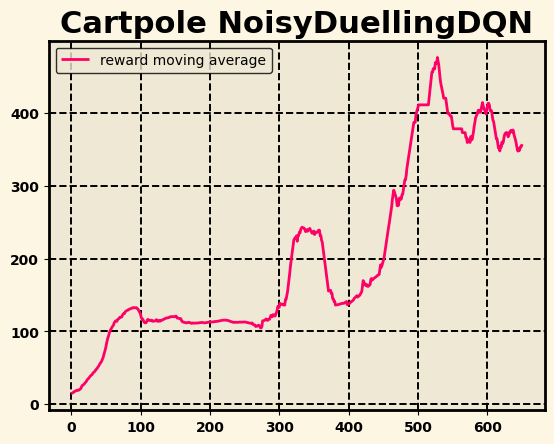

In [73]:

def moving_average(data:list,interval):
    move_average=[]
    for i in range(interval,len(data)):
        move_average.append(np.mean(data[i-interval:i]))
    return move_average    
    
plt.style.use('Solarize_Light2')
plt.plot(moving_average(rewards,50),label="reward moving average",color="#ff0066")
plt.title(f"Cartpole {PROJECT_NAME}",color="black",fontsize=22,weight='bold')
plt.tick_params(axis='both', colors='black')
plt.grid(ls="--",lw=1.4,color="black")
plt.legend(frameon=True, edgecolor='black') 
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(2)

# os.mkdir(f"./{PROJECT_NAME}")
# Save high-quality PNG
plt.savefig(f"../Result/{PROJECT_NAME}/{ENV_NAME}/Plots/plot_high_quality.png", dpi=300, bbox_inches='tight')

# Save high-quality SVG
plt.savefig(f"../Result/{PROJECT_NAME}/{ENV_NAME}/Plots/plot_high_quality.svg", format='svg', bbox_inches='tight')   

<center><b>Final Exploit

In [76]:
model.eval()
env = gym.make(ENV_NAME,render_mode = "human")
obs,_ = env.reset()
rew = 0
done = False
while not done:
    
    obs = torch.tensor(obs).reshape(1,-1).float().to((device))
    with torch.no_grad():
        action_values = model(obs)
    action = torch.argmax(action_values).item()
    new_observation ,reward,terminated,truncated,_  = env.step(action) 
    obs= new_observation
    rew+=reward
    done =  truncated or terminated
print(rew)
env.close()

151.0
